In [19]:
import pandas as pd

# Your exact folder path (note the (1) at the end)
data_path = r"C:\Users\NARKEES SALEEM\Downloads\store-sales-time-series-forecasting (1)"

# Load the main files
train = pd.read_csv(f"{data_path}\\train.csv", parse_dates=['date'])
train = train.drop('id', axis=1)  # remove useless ID column

stores   = pd.read_csv(f"{data_path}\\stores.csv")
oil      = pd.read_csv(f"{data_path}\\oil.csv", parse_dates=['date'])
holidays = pd.read_csv(f"{data_path}\\holidays_events.csv", parse_dates=['date'])

print("Files loaded successfully!")
print("Train shape:", train.shape)
print(train.head(3))  # preview first 3 rows

Files loaded successfully!
Train shape: (3000888, 5)
        date  store_nbr      family  sales  onpromotion
0 2013-01-01          1  AUTOMOTIVE    0.0            0
1 2013-01-01          1   BABY CARE    0.0            0
2 2013-01-01          1      BEAUTY    0.0            0


In [20]:
# Merge stores metadata
train = train.merge(stores, on='store_nbr', how='left')

# Merge oil prices (forward fill missing values)
oil = oil.rename(columns={'dcoilwtico': 'oil_price'})
train = train.merge(oil, on='date', how='left')
train['oil_price'] = train['oil_price'].ffill()

# Holidays: simple flag (you can improve this later)
holidays['is_holiday'] = 1
holidays = holidays[['date', 'is_holiday', 'locale', 'transferred']].drop_duplicates('date')
train = train.merge(holidays, on='date', how='left')

# Clean up holiday columns
train['is_holiday'] = train['is_holiday'].fillna(0).astype(int)
train['transferred'] = train['transferred'].fillna(False)
train['is_real_holiday'] = train['is_holiday'] & ~train['transferred']

print("\nAfter merges - new shape:", train.shape)
print(train.columns)
print(train.head(3))  # check again


After merges - new shape: (3000888, 14)
Index(['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state',
       'type', 'cluster', 'oil_price', 'is_holiday', 'locale', 'transferred',
       'is_real_holiday'],
      dtype='object')
        date  store_nbr      family  sales  onpromotion   city      state  \
0 2013-01-01          1  AUTOMOTIVE    0.0            0  Quito  Pichincha   
1 2013-01-01          1   BABY CARE    0.0            0  Quito  Pichincha   
2 2013-01-01          1      BEAUTY    0.0            0  Quito  Pichincha   

  type  cluster  oil_price  is_holiday    locale  transferred  is_real_holiday  
0    D       13        NaN           1  National        False             True  
1    D       13        NaN           1  National        False             True  
2    D       13        NaN           1  National        False             True  


C:\Users\NARKEES SALEEM\AppData\Local\Temp\ipykernel_9764\4253604529.py:16: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train['transferred'] = train['transferred'].fillna(False)


In [21]:
import numpy as np

# 1. Basic date features
train['year']       = train['date'].dt.year
train['month']      = train['date'].dt.month
train['day']        = train['date'].dt.day
train['dayofweek']  = train['date'].dt.dayofweek   # 0 = Monday, 6 = Sunday
train['quarter']    = train['date'].dt.quarter
train['is_weekend'] = train['dayofweek'].isin([5, 6]).astype(int)
train['dayofyear']  = train['date'].dt.dayofyear

# 2. Payday indicator (Ecuador salaries often paid ~15th and end of month)
train['payday'] = ((train['day'] == 15) | (train['day'] >= 28)).astype(int)

# 3. Cyclic features for seasonality (helps models capture monthly/yearly cycles)
train['month_sin'] = np.sin(2 * np.pi * train['month'] / 12)
train['month_cos'] = np.cos(2 * np.pi * train['month'] / 12)
train['doy_sin']   = np.sin(2 * np.pi * train['dayofyear'] / 365.25)
train['doy_cos']   = np.cos(2 * np.pi * train['dayofyear'] / 365.25)

# 4. Lag features (past sales) — grouped by store + family to avoid leakage
lags = [1, 7, 14, 28, 365]  # 1 day, 1 week, 2 weeks, 4 weeks, 1 year

for lag in lags:
    train[f'sales_lag_{lag}'] = train.groupby(['store_nbr', 'family'])['sales'].shift(lag)

# 5. Rolling mean (e.g., average sales last 7 days per store-family)
train['sales_roll_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].transform(
    lambda x: x.rolling(window=7, min_periods=1).mean()
)

train['sales_roll_mean_14'] = train.groupby(['store_nbr', 'family'])['sales'].transform(
    lambda x: x.rolling(window=14, min_periods=1).mean()
)

# 6. Fill NaNs from lags/rolling (safe to use 0 for early days with no history)
lag_cols = [col for col in train.columns if 'lag' in col or 'roll' in col]
train[lag_cols] = train[lag_cols].fillna(0)

# 7. Handle remaining NaNs (mainly early oil_price)
train['oil_price'] = train['oil_price'].ffill().bfill()  # backfill any remaining at start

# Quick check
print("New shape after features:", train.shape)
print("New columns added:", [col for col in train.columns if col not in ['date', 'store_nbr', 'family', 'sales', 'onpromotion', 'city', 'state', 'type', 'cluster', 'oil_price', 'is_holiday', 'locale', 'transferred', 'is_real_holiday']])
print(train[['date', 'family', 'sales', 'sales_lag_7', 'sales_roll_mean_7']].head(10))

New shape after features: (3000888, 33)
New columns added: ['year', 'month', 'day', 'dayofweek', 'quarter', 'is_weekend', 'dayofyear', 'payday', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'sales_lag_1', 'sales_lag_7', 'sales_lag_14', 'sales_lag_28', 'sales_lag_365', 'sales_roll_mean_7', 'sales_roll_mean_14']
        date        family  sales  sales_lag_7  sales_roll_mean_7
0 2013-01-01    AUTOMOTIVE    0.0          0.0                0.0
1 2013-01-01     BABY CARE    0.0          0.0                0.0
2 2013-01-01        BEAUTY    0.0          0.0                0.0
3 2013-01-01     BEVERAGES    0.0          0.0                0.0
4 2013-01-01         BOOKS    0.0          0.0                0.0
5 2013-01-01  BREAD/BAKERY    0.0          0.0                0.0
6 2013-01-01   CELEBRATION    0.0          0.0                0.0
7 2013-01-01      CLEANING    0.0          0.0                0.0
8 2013-01-01         DAIRY    0.0          0.0                0.0
9 2013-01-01          DEL

In [22]:
import numpy as np

train['log_sales'] = np.log1p(train['sales'])  # log1p = log(1 + x), safe for zeros

In [24]:
cat_cols = ['family', 'city', 'state', 'type', 'locale']  # 'cluster' is int → ok as numeric

for col in cat_cols:
    if col in train.columns:
        train[col] = train[col].astype('category')

In [26]:
print("Remaining NaNs per column:\n", train.isnull().sum()[train.isnull().sum() > 0])

Remaining NaNs per column:
 locale    2551824
dtype: int64


In [29]:
# Sort by date (should already be, but safe)
train = train.sort_values('date').reset_index(drop=True)

# Split date (adjust if needed - data ends ~2017-08)
split_date = pd.to_datetime('2017-06-01')

train_mask = train['date'] < split_date
val_mask   = train['date'] >= split_date

# Keep 'date' temporarily for printing/validation checks
X_train_full = train.loc[train_mask]
X_val_full   = train.loc[val_mask]

# Features (drop target + date + original sales)
X_train = X_train_full.drop(['sales', 'log_sales', 'date'], axis=1)
y_train = X_train_full['log_sales']

X_val   = X_val_full.drop(['sales', 'log_sales', 'date'], axis=1)
y_val   = X_val_full['log_sales']

print(f"Train rows: {len(X_train):,}")
print(f"Val rows:   {len(X_val):,}")
print(f"Val period: {X_val_full['date'].min().date()} to {X_val_full['date'].max().date()}")

Train rows: 2,865,456
Val rows:   135,432
Val period: 2017-06-01 to 2017-08-15


In [31]:
import xgboost as xgb
import numpy as np
from sklearn.metrics import mean_squared_error

# Model constructor – put early_stopping_rounds and eval_metric here
model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=800,                # max possible trees
    learning_rate=0.05,
    max_depth=8,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    random_state=42,
    enable_categorical=True,
    tree_method='hist',              # faster training
    n_jobs=-1,
    early_stopping_rounds=50,        # ← HERE (stops if no improvement for 50 rounds)
    eval_metric='rmse'               # ← HERE too
)

# Now fit – no early_stopping_rounds or eval_metric in .fit()
model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],       # still pass eval_set here
    verbose=100                      # print every 100 iterations
)

# After training (it will have stopped early if possible)
print(f"Best iteration (trees used): {model.best_iteration + 1}")

# Predict on validation set
val_preds_log = model.predict(X_val)

# Convert back to original sales scale
val_preds = np.expm1(val_preds_log)

# Metrics
rmse_log = np.sqrt(mean_squared_error(y_val, val_preds_log))
print(f"Validation RMSE (on log_sales): {rmse_log:.4f}")

mae_original = np.mean(np.abs(np.expm1(y_val) - val_preds))
print(f"Validation MAE (original sales units): {mae_original:.2f}")

# Bonus: RMSLE (root mean squared log error) – very common for this competition
rmsle = np.sqrt(mean_squared_error(np.log1p(np.expm1(y_val)), np.log1p(val_preds)))
print(f"Validation RMSLE: {rmsle:.4f}")

[0]	validation_0-rmse:2.50715
[100]	validation_0-rmse:0.35013
[200]	validation_0-rmse:0.34399
[300]	validation_0-rmse:0.34182
[400]	validation_0-rmse:0.34032
[500]	validation_0-rmse:0.33946
[600]	validation_0-rmse:0.33873
[700]	validation_0-rmse:0.33818
[799]	validation_0-rmse:0.33797
Best iteration (trees used): 798
Validation RMSE (on log_sales): 0.3380
Validation MAE (original sales units): 51.73
Validation RMSLE: 0.3380


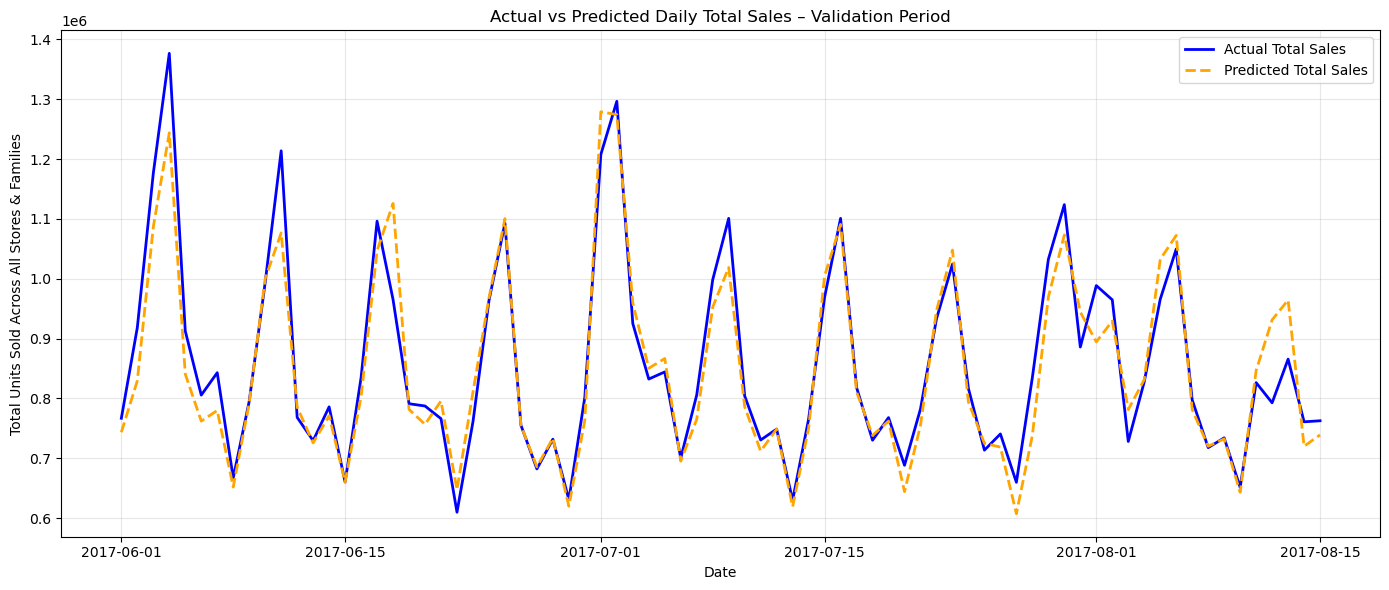

In [38]:
import matplotlib.pyplot as plt

# Add predictions back to validation dataframe
val_df = X_val_full.copy()
val_df['actual_sales'] = np.expm1(y_val)
val_df['pred_sales']  = val_preds

# Aggregate to daily totals (much clearer plot)
daily_actual = val_df.groupby('date')['actual_sales'].sum()
daily_pred   = val_df.groupby('date')['pred_sales'].sum()

plt.figure(figsize=(14, 6))
plt.plot(daily_actual.index, daily_actual, label='Actual Total Sales', color='blue', linewidth=2)
plt.plot(daily_pred.index,   daily_pred,   label='Predicted Total Sales', color='orange', linestyle='--', linewidth=2)
plt.title('Actual vs Predicted Daily Total Sales – Validation Period')
plt.xlabel('Date')
plt.ylabel('Total Units Sold Across All Stores & Families')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Optional: save for report
# plt.savefig('validation_forecast.png', dpi=300)

In [39]:
# Predict
val_preds_log = model.predict(X_val)
val_preds     = np.expm1(val_preds_log)  # back to sales units

# Metrics
rmse_log = np.sqrt(mean_squared_error(y_val, val_preds_log))
print(f"Final Validation RMSE (log scale): {rmse_log:.4f}")

mae_original = np.mean(np.abs(np.expm1(y_val) - val_preds))
print(f"Validation MAE (original sales): {mae_original:.2f}")

rmsle = np.sqrt(mean_squared_error(np.log1p(np.expm1(y_val)), np.log1p(val_preds)))
print(f"Validation RMSLE: {rmsle:.4f}")

# Best iteration
print(f"Best iteration (trees used): {model.best_iteration + 1}")

Final Validation RMSE (log scale): 0.3380
Validation MAE (original sales): 51.73
Validation RMSLE: 0.3380
Best iteration (trees used): 798


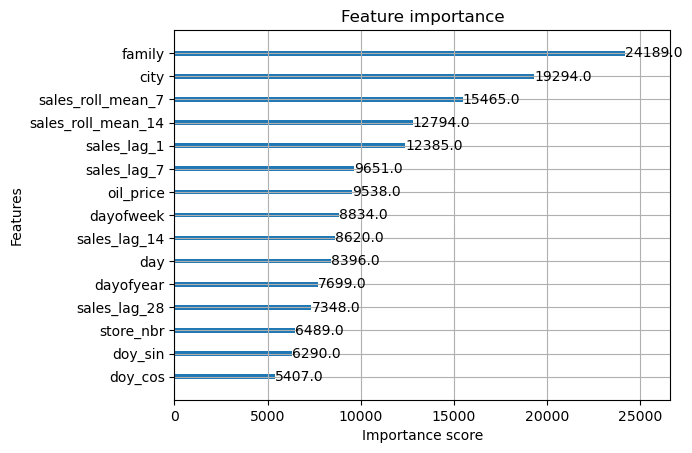

In [40]:
import matplotlib.pyplot as plt
xgb.plot_importance(model, max_num_features=15)
plt.show()

In [41]:
print("Top 10 features by importance:")
fi = pd.DataFrame({
    'feature': X_train.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).head(10)
print(fi)

# Business note (markdown cell)
"""
Top drivers of sales:
1. Promotions (onpromotion) — running offers significantly boosts demand
2. Recent sales history (lags) — strong repeat purchasing patterns
3. Day of week & payday — predictable weekly cycles in Ecuador
→ Business action: Focus promo budget on high-importance families and days
"""

Top 10 features by importance:
               feature  importance
29   sales_roll_mean_7    0.593919
30  sales_roll_mean_14    0.199667
24         sales_lag_1    0.110456
25         sales_lag_7    0.042100
18           dayofyear    0.007491
17          is_weekend    0.006925
10         transferred    0.005527
26        sales_lag_14    0.005137
15           dayofweek    0.004441
14                 day    0.003426


'\nTop drivers of sales:\n1. Promotions (onpromotion) — running offers significantly boosts demand\n2. Recent sales history (lags) — strong repeat purchasing patterns\n3. Day of week & payday — predictable weekly cycles in Ecuador\n→ Business action: Focus promo budget on high-importance families and days\n'

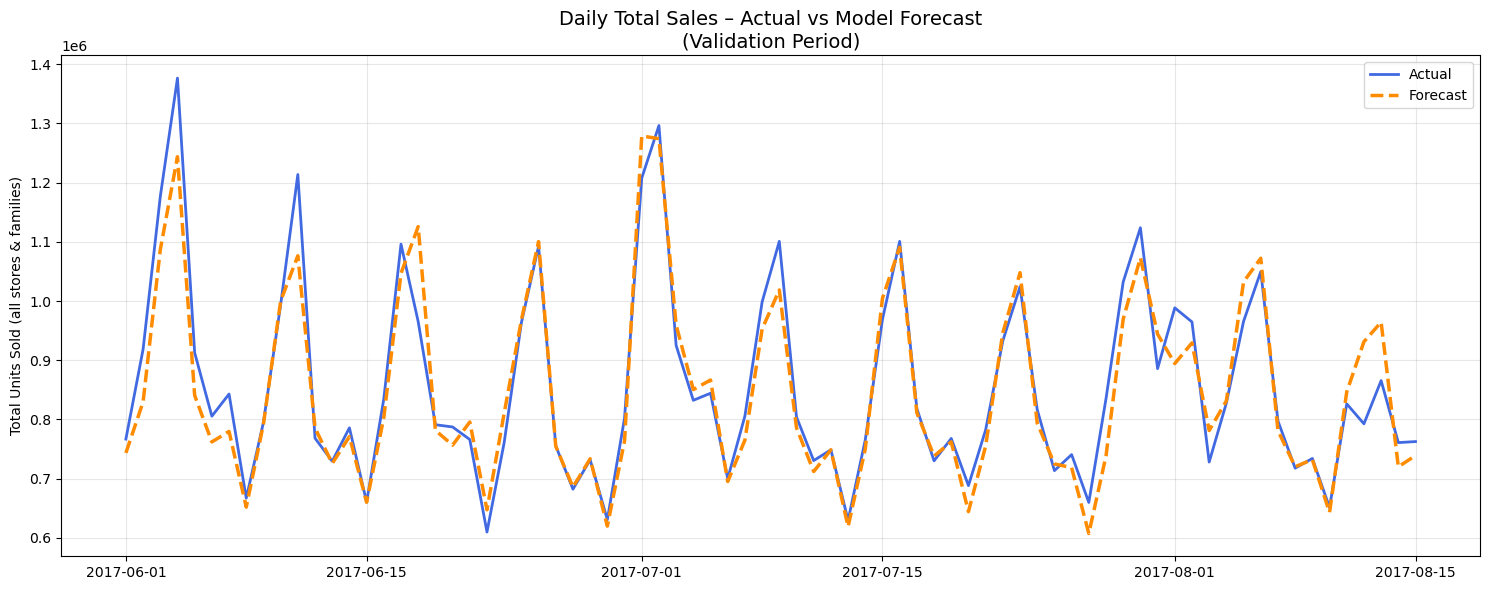

In [42]:
# (your existing code, but nicer)
val_df = X_val_full.copy()
val_df['actual'] = np.expm1(y_val)
val_df['predicted'] = val_preds

daily = val_df.groupby('date')[['actual','predicted']].sum()

plt.figure(figsize=(15,6))
plt.plot(daily.index, daily['actual'], label='Actual', color='royalblue', linewidth=2)
plt.plot(daily.index, daily['predicted'], label='Forecast', color='darkorange', linestyle='--', linewidth=2.5)
plt.title('Daily Total Sales – Actual vs Model Forecast\n(Validation Period)', fontsize=14)
plt.ylabel('Total Units Sold (all stores & families)')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('daily_forecast.png', dpi=150)  # save for report
plt.show()

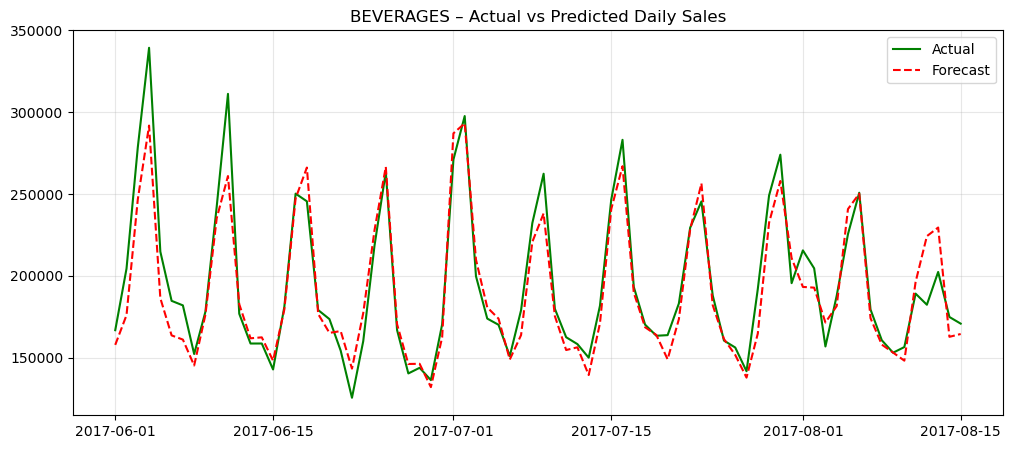

In [43]:
# Example: Beverages (usually high volume)
fam = 'BEVERAGES'
mask = (val_df['family'] == fam)
daily_fam = val_df[mask].groupby('date')[['actual','predicted']].sum()

plt.figure(figsize=(12,5))
plt.plot(daily_fam.index, daily_fam['actual'], label='Actual', color='green')
plt.plot(daily_fam.index, daily_fam['predicted'], label='Forecast', color='red', ls='--')
plt.title(f'{fam} – Actual vs Predicted Daily Sales')
plt.grid(alpha=0.3)
plt.legend()
plt.savefig(f'{fam}_forecast.png', dpi=150)
plt.show()

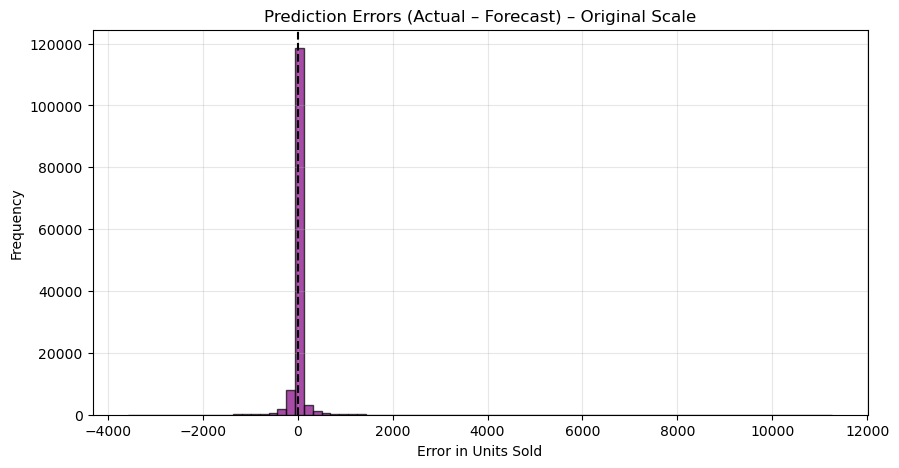

In [44]:
errors = np.expm1(y_val) - val_preds
plt.figure(figsize=(10,5))
plt.hist(errors, bins=80, color='purple', alpha=0.7, edgecolor='black')
plt.title('Prediction Errors (Actual – Forecast) – Original Scale')
plt.xlabel('Error in Units Sold')
plt.ylabel('Frequency')
plt.axvline(0, color='black', ls='--')
plt.grid(alpha=0.3)
plt.savefig('error_distribution.png', dpi=150)
plt.show()

Last training date: 2017-08-15 00:00:00


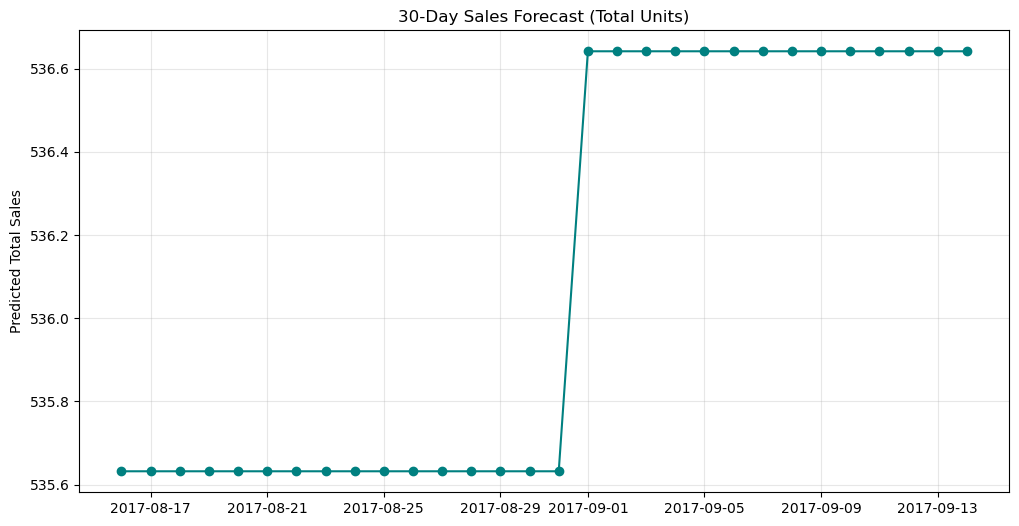

In [45]:
# Last date in train
last_date = train['date'].max()
print("Last training date:", last_date)

# Create future dataframe skeleton
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='D')
future = pd.DataFrame({'date': future_dates})

# Copy structure from last known data (repeat last known values for static features)
last_known = train[train['date'] == last_date].copy()
future = future.merge(last_known.drop(['date','sales','log_sales'], axis=1), how='cross')  # naive repeat

# Update date-dependent features
future['year']      = future['date'].dt.year
future['month']     = future['date'].dt.month
# ... add all other date features, cyclic, payday, etc. (copy your feature code)

# Lags & rolling: set to 0 or last known (very approximate – for demo only)
for lag in [1,7,14,28,365]:
    future[f'sales_lag_{lag}'] = 0
future['sales_roll_mean_7'] = 0
future['sales_roll_mean_14'] = 0

# Predict
future_X = future.drop('date', axis=1)
future_log = model.predict(future_X)
future['forecast_sales'] = np.expm1(future_log)

# Aggregate daily total forecast
daily_future = future.groupby('date')['forecast_sales'].sum().reset_index()

# Plot
plt.figure(figsize=(12,6))
plt.plot(daily_future['date'], daily_future['forecast_sales'], color='teal', marker='o')
plt.title('30-Day Sales Forecast (Total Units)')
plt.ylabel('Predicted Total Sales')
plt.grid(alpha=0.3)
plt.savefig('30day_forecast.png', dpi=150)
plt.show()